In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from helpers import *

import warnings

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
plt.rcdefaults()

In [109]:
DATA_FOLDER = "../Data/"

movies_imdb = pd.read_csv(DATA_FOLDER + 'movies_imdb.csv',
                          converters={'languages': parse_list, 'countries': parse_list, 'genresCmu': parse_list,
                                      'genresImdb': parse_list})

In [110]:
combinedGenres = movies_imdb.genresImdb.apply(
    lambda x: x if isinstance(x, list) else []
) + movies_imdb.genresCmu.apply(lambda x: x if isinstance(x, list) else [])

combinedGenres = combinedGenres.apply(lambda x: set(x) if len(x)>0 else np.nan)

movies_imdb["combinedGenres"]= combinedGenres

In [111]:
genres = movies_imdb.dropna(subset="combinedGenres").explode(column="combinedGenres").combinedGenres.values
genres_unique = np.unique(genres)


In [112]:
genres_str = " ".join(str(g) for g in genres)

In [113]:
split_characters = set()
for m in genres_str:
    for l in m:
        if not l.isalpha() and l != " ":
            split_characters.add(l)

split_characters

{'&', "'", '-', '/', '5', '9', '[', ']'}

In [114]:
string = genres_str
for delimiter in split_characters:
    string = " ".join(string.split(delimiter))
    
words = string.split(" ")

In [115]:
import nltk
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

words = list(map(lambda x: x.lower(), words)) #tout en minuscule
words = list(map(lambda x:lemmatizer.lemmatize(x), words)) #enlever les s
ags = nltk.pos_tag(words) # dire si c'est un verbe adjectif etc
words_, tags= np.array(list(map(list, zip(*ags))))

In [116]:
mask = (tags == np.array(["NN","NNS","NNP","NNPS","JJ"]).reshape(-1,1)).any(axis=0) # grader que les nouns et les adjs


In [117]:
counts = pd.Series(words_[mask]).value_counts()
themes = pd.Series(counts[counts > 2000]).index
themes 

Index(['drama', 'film', 'comedy', 'action', 'romance', 'thriller', 'crime',
       'adventure', 'fiction', 'short', 'black', 'white', 'family', 'cinema',
       'world', 'movie', 'indie', 'horror', 'romantic', 'documentary',
       'silent', 'musical', 'fantasy', 'animation', 'mystery', 'war', '',
       'science', 'western', 'japanese', 'biography'],
      dtype='object')

In [118]:
themes = list(themes)
to_remove = [
    "", #remove null caracter 
    "film",
    "cinema",
    "movie",  # comes from genres like "Romance Film" not a genre in itself.
    "black",
    "white",  # will add "black-and-white" instead of having both
    "science", # only science fiction contained in fiction
]
for r in to_remove:
    themes.remove(r)
themes.append("black-and-white")
themes = list(map(lambda x:x.capitalize(), themes))

In [119]:
genres_dict = {theme: set() for theme in themes}
for theme in themes:
    for genre in genres_unique:
        if theme.lower() in genre.lower():
            genres_dict[theme].add(genre)


genres_dict["Romance"]= genres_dict["Romance"].union(genres_dict.pop("Romantic"));
themes.remove("Romantic")

print(len(themes) ,"themes :",themes)

24 themes : ['Drama', 'Comedy', 'Action', 'Romance', 'Thriller', 'Crime', 'Adventure', 'Fiction', 'Short', 'Family', 'World', 'Indie', 'Horror', 'Documentary', 'Silent', 'Musical', 'Fantasy', 'Animation', 'Mystery', 'War', 'Western', 'Japanese', 'Biography', 'Black-and-white']


In [120]:
genres_dict["Drama"]

{'Addiction Drama',
 'Childhood Drama',
 'Comedy-drama',
 'Costume drama',
 'Courtroom Drama',
 'Crime Drama',
 'Docudrama',
 'Drama',
 'Erotic Drama',
 'Family Drama',
 'Fantasy Drama',
 'Historical drama',
 'Inspirational Drama',
 'Legal drama',
 'Marriage Drama',
 'Melodrama',
 'Musical Drama',
 'Political drama',
 'Romantic drama'}

In [121]:
def unify_genres(x):
    try:
        unified_genres = set()
        for genre in x:
            themes_in_genres = {t for t in themes if genre in genres_dict[t]}
            unified_genres= unified_genres.union(themes_in_genres)
        return unified_genres if unified_genres else np.nan

    except TypeError: 
        return x
        

In [122]:
genres_final = movies_imdb.combinedGenres.apply(unify_genres)
(genres_final.isnull()).sum()

3339

In [123]:
movies_imdb["unifiedGenres"] = movies_imdb.combinedGenres.apply(unify_genres)

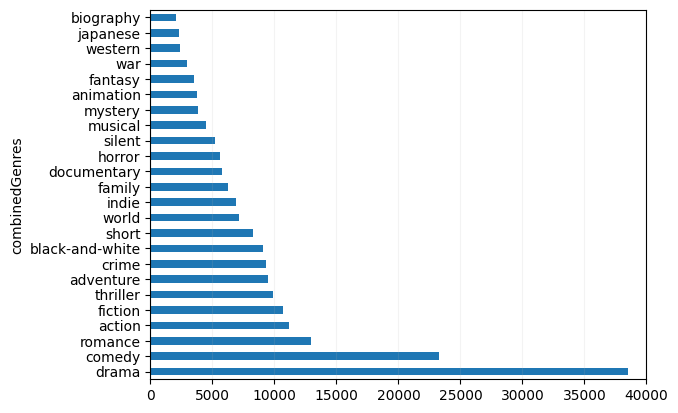

In [ ]:
genres_final.explode().value_counts().plot(kind='barh')
plt.xlim([0,4e4])
plt.grid(alpha=0.15, axis="x")

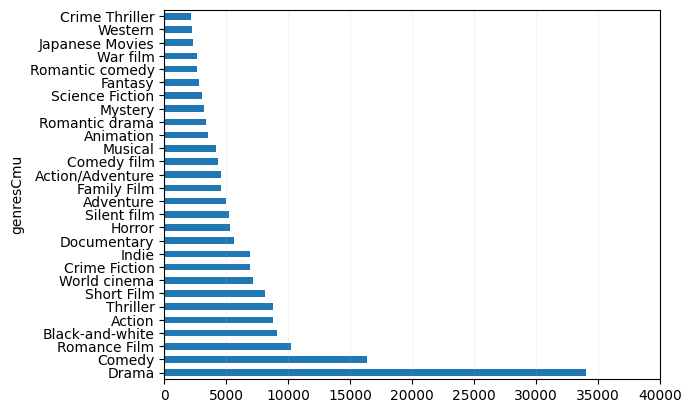

In [ ]:
occurences = movies_imdb.genresCmu.explode().value_counts()
occurences[occurences>2000].plot(kind='barh')
plt.xlim([0,4e4])
plt.grid(alpha=0.15, axis="x")

In [124]:
movies_imdb.unifiedGenres

0                                  {Mystery, Drama, Crime}
1                                  {Drama, Fiction, Crime}
2                                               {Thriller}
3                                                  {Drama}
4          {Silent, Comedy, Black-and-white, Indie, Short}
                               ...                        
81625                                              {Drama}
81626                                 {Drama, Documentary}
81627                                             {Comedy}
81628    {Adventure, Animation, Drama, Japanese, Fictio...
81629                                   {Thriller, Horror}
Name: unifiedGenres, Length: 81630, dtype: object

In [127]:
movies_imdb.drop("combinedGenres",inplace=True, axis=1)

In [128]:
movies_imdb

,wikiID,fbID,name,boxOffice,runtime,languages,countries,genresCmu,releaseMonth,releaseYear,imdbID,titleType,originalTitle,isAdult,endYear,genresImdb,averageRating,numVotes,budget,popularity,unifiedGenres
0,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",2.0,2000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{Mystery, Drama, Crime}"
1,28463795,/m/0crgdbh,Brun bitter,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]",NaN,1988.0,tt0094806,movie,Brun bitter,0.0,\N,"[Crime, Drama]",5.6,40.0,NaN,NaN,"{Drama, Fiction, Crime}"
2,9363483,/m/0285_cd,White Of The Eye,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",NaN,1987.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,{Thriller}
3,261236,/m/01mrr1,A Woman in Flames,NaN,106.0,[German Language],[Germany],[Drama],NaN,1983.0,tt0083949,movie,Die flambierte Frau,0.0,\N,[Drama],6.0,621.0,NaN,NaN,{Drama}
4,13696889,/m/03cfc81,The Gangsters,NaN,35.0,"[Silent film, English Language]",[United States of America],"[Short Film, Silent film, Indie, Black-and-whi...",5.0,1913.0,tt0002894,short,The Gangsters,0.0,\N,"[Comedy, Short]",6.8,16.0,NaN,NaN,"{Silent, Comedy, Black-and-white, Indie, Short}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81625,35228177,/m/0j7hxnt,Mermaids: The Body Found,NaN,120.0,[English Language],[United States of America],[Drama],3.0,2011.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,{Drama}
81626,34980460,/m/0g4pl34,Knuckle,NaN,96.0,[English Language],"[Ireland, United Kingdom]","[Biographical film, Drama, Documentary]",1.0,2011.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{Drama, Documentary}"
81627,9971909,/m/02pygw1,Another Nice Mess,NaN,66.0,[English Language],[United States of America],"[Satire, Comedy]",9.0,1972.0,tt0362411,movie,Another Nice Mess,0.0,\N,[Comedy],5.8,110.0,NaN,NaN,{Comedy}
81628,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,NaN,150.0,[Japanese Language],[Japan],"[Science Fiction, Japanese Movies, Adventure, ...",5.0,1992.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{Adventure, Animation, Drama, Japanese, Fictio..."


In [129]:
# save preprocessed dataframe to csv
movies_imdb.to_csv(DATA_FOLDER + "movies_imdb.csv", index=False)

In [130]:
movies_imdb = pd.read_csv(DATA_FOLDER + 'movies_imdb.csv',
                          converters={'languages': parse_list, 'countries': parse_list, 'genresCmu': parse_list,
                                      'genresImdb': parse_list, 'unifiedGenres': parse_list})

In [134]:
movies_imdb.unifiedGenres.explode().unique()

array(['Mystery', 'Drama', 'Crime', 'Fiction', 'Thriller',
       'Black-and-white', 'Silent', 'Comedy', 'Indie', 'Short',
       'Adventure', 'World', 'Fantasy', 'Family', 'Musical', 'Horror',
       'Romance', 'Japanese', 'Action', 'Biography', 'War', 'Animation',
       nan, 'Western', 'Documentary'], dtype=object)